In [1]:
!pip install np_utils seaborn keras-tuner --quiet

In [2]:
import os
import logging
import itertools
from joblib import dump, load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from wordcloud import WordCloud
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import keras_tuner
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding
from keras.utils import to_categorical
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2024-07-26 22:26:55.939991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 22:26:55.953633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 22:26:55.958039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 22:26:55.973279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available: 1


I0000 00:00:1722032817.352383   31422 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722032817.365930   31422 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722032817.365982   31422 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
from keras import backend as K
K.clear_session()

#### Data preprocessing of "labeled_data.csv" hate speech dataset

In [4]:
text = []
clas = []
df = pd.read_csv('labeled_data.csv') # Load hate speech data
text = df['tweet'].tolist()
clas = df['class'].tolist()
df = pd.DataFrame({'tweet': text, 'class': clas}) # Recreate hate speech dataframe
print(df.isnull().sum())
df['tweet'] = df['tweet'].apply(lambda x:x.lower()) # Make lowercase
punctuation_signs = list("?:!.,;")
df['tweet'] = df['tweet']

for punct_sign in punctuation_signs:
    df['tweet'] = df['tweet'].str.replace(punct_sign, '')

df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ' '))
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ' '))
df['tweet'] = df['tweet'].str.replace("    ", " ")
df['tweet'] = df['tweet'].str.replace('"', '')
df['tweet'] = df['tweet'].str.replace("'s", "")

tweet    0
class    0
dtype: int64


In [5]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['tweet'] = df['tweet'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### ML dataset split

In [6]:
cv = CountVectorizer(max_features = 75)
X = cv.fit_transform(df['tweet']).toarray()
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)
y_train=to_categorical(y_train, num_classes = 3)
y_test=to_categorical(y_test, num_classes = 3)

#### Model architecture

In [7]:
# Define LSTM model architecture


def LSTM_model(lr, activation):
    model = Sequential()
    model.add(Embedding(232337, 100))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    return model



#### Hyperparameter grid search

In [8]:


def build_model(hp):
    activation = hp.Choice("activation", ["relu", "tanh", "elu", "sigmoid"])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = LSTM_model(lr=lr, activation=activation)
    return model


build_model(keras_tuner.HyperParameters())

I0000 00:00:1722032825.214836   31422 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722032825.214924   31422 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722032825.214957   31422 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722032825.456803   31422 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722032825.456889   31422 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26

<Sequential name=sequential, built=False>

In [9]:
tuner = keras_tuner.GridSearch(
    build_model,
    objective="val_loss",
    overwrite=True,
    max_trials=100,
    seed=123)


tuner.search(X_train, y_train, validation_data=(X_test,y_test), epochs=1)

Trial 44 Complete [00h 02m 00s]
val_loss: 0.4022296965122223

Best val_loss So Far: 0.40195000171661377
Total elapsed time: 01h 30m 17s


In [10]:
# Get the optimal hyperparameters and model
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

best_model = tuner.get_best_models()[0]
best_model.summary()

{'activation': 'sigmoid', 'lr': 0.003162277660168381}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 75, 100)        │    23,233,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 75, 100)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,243,443 (88.67 MB)

 Trainable params: 23,243,443 (88.67 MB)

 Non-trainable params: 0 (0.00 B)

#### LSTM model training

In [11]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Epoch 1/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 126s 201ms/step - accuracy: 0.7655 - loss: 0.4176 - val_accuracy: 0.7743 - val_loss: 0.4022
Epoch 2/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 123s 198ms/step - accuracy: 0.7703 - loss: 0.4044 - val_accuracy: 0.7743 - val_loss: 0.4018
Epoch 3/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 121s 194ms/step - accuracy: 0.7771 - loss: 0.3972 - val_accuracy: 0.7743 - val_loss: 0.4019
Epoch 4/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 123s 198ms/step - accuracy: 0.7735 - loss: 0.4011 - val_accuracy: 0.7743 - val_loss: 0.4027
Epoch 5/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 124s 200ms/step - accuracy: 0.7700 - loss: 0.4042 - val_accuracy: 0.7743 - val_loss: 0.4018
Epoch 6/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 121s 196ms/step - accuracy: 0.7755 - loss: 0.3979 - val_accuracy: 0.7743 - val_loss: 0.4016
Epoch 7/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 122s 197ms/step - accuracy: 0.7701 - loss: 0.4037 - val_accuracy: 0.7743 - val_loss: 0.4019
Epoch 8/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 121s 195ms/step - accuracy: 

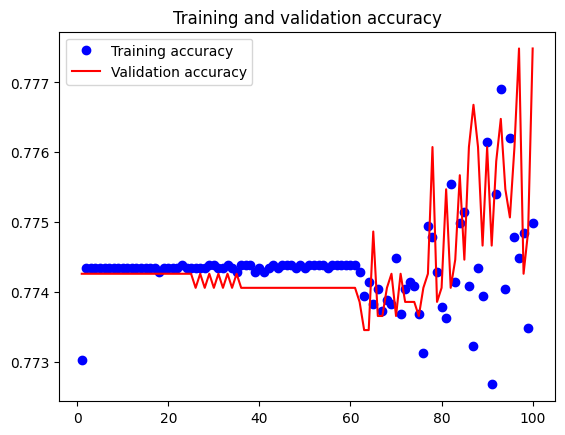

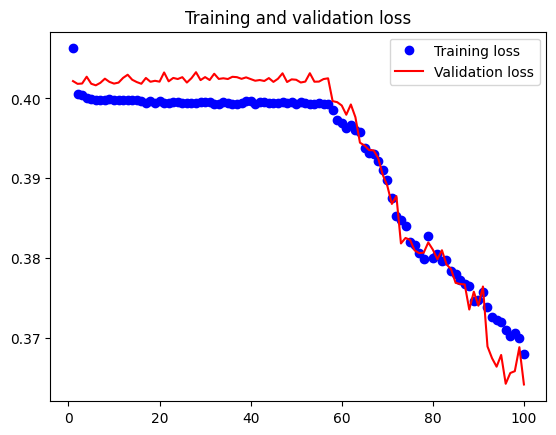

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
model.save('keras_weights/hs_lstm_baseline.h5')

#### Baseline LSTM model evaluation

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
# Predict and calculate confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step


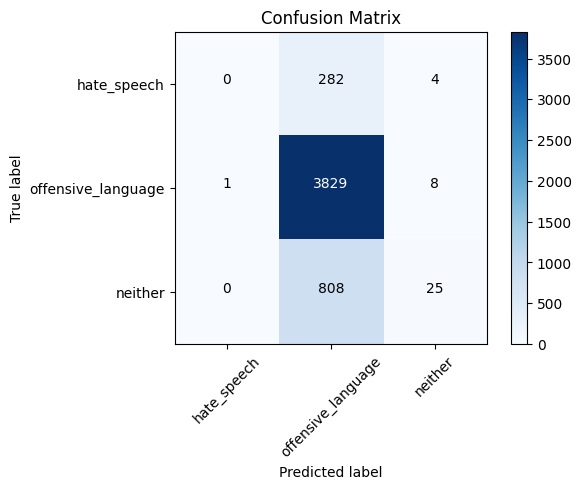

In [16]:
class_names = ['hate_speech', 'offensive_language', 'neither']
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
plt.show()

In [53]:
from sklearn.metrics import f1_score, classification_report
print('F1 = ', f1_score(y_true, y_pred_classes, average='macro'))
print('')
print(classification_report(y_true, y_pred_classes, target_names=['hate_speech','offensive_language','neither']))

F1 =  0.3106572213493573

                    precision    recall  f1-score   support

       hate_speech       0.00      0.00      0.00       286
offensive_language       0.78      1.00      0.87      3838
           neither       0.68      0.03      0.06       833

          accuracy                           0.78      4957
         macro avg       0.48      0.34      0.31      4957
      weighted avg       0.72      0.78      0.69      4957



#### 2nd labeled hate speech test dataset (unseen by LSTM model)

In [42]:
# Read in Dynamically-Generated-Hate-Dataset v0.2.3 file
fpath = r"DGHatev0_2_3.csv"
dgh = pd.read_csv(fpath)
dgh.head()

,Unnamed: 0,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,1,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,2,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,3,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,4,acl1000,4,I'm not saying we should actually eliminate he...,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,5,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN


In [43]:
dgh['label'].unique()

array(['hate', 'nothate'], dtype=object)

In [44]:
# Change variable names and observation classes
dgh.rename(columns={'text': 'tweet', 'label': 'class'}, inplace=True)
dgh['class'] = dgh['class'].map({'hate':0, 'nothate':2})

In [45]:
# Preprocess DGH dataset
X_dgh = cv.fit_transform(dgh['tweet']).toarray()
y_dgh = dgh['class']
y_dgh = to_categorical(y_dgh, num_classes = 3)

#### Evaluate baseline LSTM model on labeled dgh examples

In [46]:
# Predict and calculate confusion matrix
y_dgh_pred = model.predict(X_dgh)
y_dgh_pred_classes = np.argmax(y_dgh_pred, axis=1)
y_dgh_true = np.argmax(y_dgh, axis=1)
cm = confusion_matrix(y_dgh_true, y_dgh_pred_classes)

1286/1286 ━━━━━━━━━━━━━━━━━━━━ 60s 46ms/step


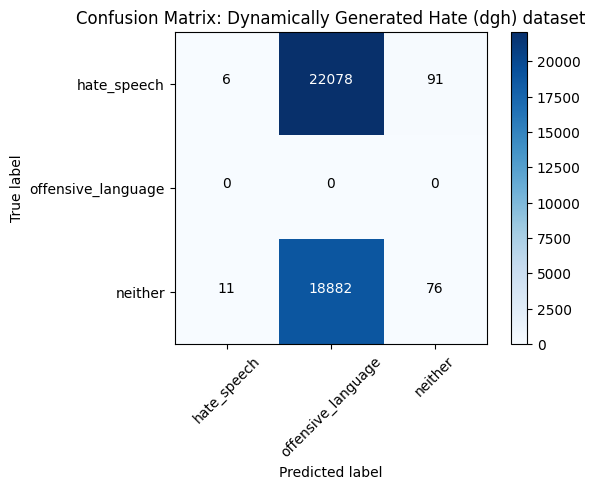

In [47]:
class_names = ['hate_speech', 'offensive_language', 'neither']
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix: Dynamically Generated Hate (dgh) dataset')
plt.show()

In [54]:
print('F1 = ', f1_score(y_dgh_true, y_dgh_pred_classes, average='macro'))
print('')
print(classification_report(y_dgh_true, y_dgh_pred_classes, target_names=['hate_speech','offensive_language','neither']))

F1 =  0.002827959737617742

                    precision    recall  f1-score   support

       hate_speech       0.35      0.00      0.00     22175
offensive_language       0.00      0.00      0.00         0
           neither       0.46      0.00      0.01     18969

          accuracy                           0.00     41144
         macro avg       0.27      0.00      0.00     41144
      weighted avg       0.40      0.00      0.00     41144



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Improve baseline LSTM with additional labeled dgh examples

In [56]:
# Split dgh datasets
dgh_train = dgh[dgh['split']=='train']
dgh_test = dgh[dgh['split']=='test']
# Preprocess DGH datasets
X_dgh_train = cv.fit_transform(dgh_train['tweet']).toarray()
y_dgh_train = dgh_train['class']
y_dgh_train = to_categorical(y_dgh_train, num_classes = 3)

y_dgh_test = dgh_test['class']
X_dgh_test = cv.fit_transform(dgh_test['tweet']).toarray()
y_dgh_test = to_categorical(y_dgh_test, num_classes = 3)

In [61]:
K.clear_session()
# Reload the baseline LSTM model and train it on the data for 200 epochs
from keras.saving import load_model
model = load_model('keras_weights/hs_lstm_baseline.h5', compile=True, safe_mode=True)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.003162277660168381), metrics=['accuracy'])
history = model.fit(X_dgh_train, y_dgh_train, validation_data=(X_dgh_test, y_dgh_test), epochs=200)

Epoch 1/200
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 191s 184ms/step - accuracy: 0.4780 - loss: 0.5390 - val_accuracy: 0.5502 - val_loss: 0.4592
Epoch 2/200
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 189s 184ms/step - accuracy: 0.5273 - loss: 0.4618 - val_accuracy: 0.5495 - val_loss: 0.4588
Epoch 3/200
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 187s 182ms/step - accuracy: 0.5388 - loss: 0.4607 - val_accuracy: 0.5502 - val_loss: 0.4594
Epoch 4/200
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 185s 180ms/step - accuracy: 0.5417 - loss: 0.4602 - val_accuracy: 0.5510 - val_loss: 0.4587
Epoch 5/200
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 186s 180ms/step - accuracy: 0.5371 - loss: 0.4606 - val_accuracy: 0.5495 - val_loss: 0.4589
Epoch 6/200
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 187s 181ms/step - accuracy: 0.5409 - loss: 0.4600 - val_accuracy: 0.5485 - val_loss: 0.4589
Epoch 7/200
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 187s 181ms/step - accuracy: 0.5383 - loss: 0.4603 - val_accuracy: 0.5466 - val_loss: 0.4590
Epoch 8/200
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 187s 182ms/s

In [62]:
model.save('keras_weights/hs_lstm_post_dgh.keras')

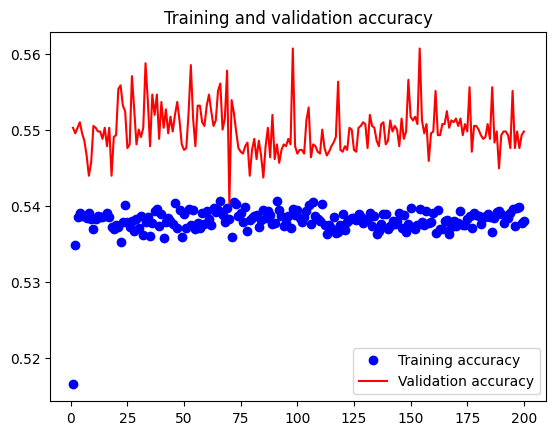

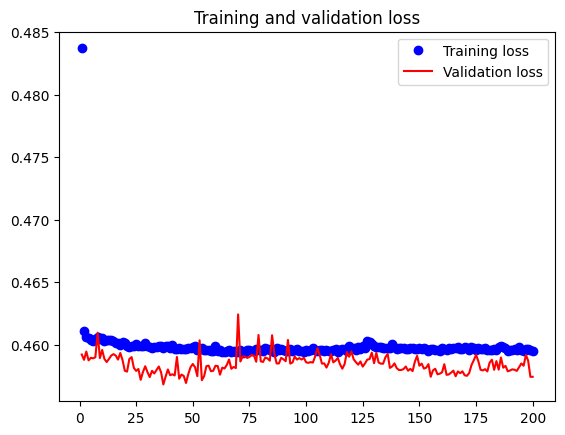

In [63]:
# Show results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Re-evaluate class predictions with labeled_data test dataset

155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step


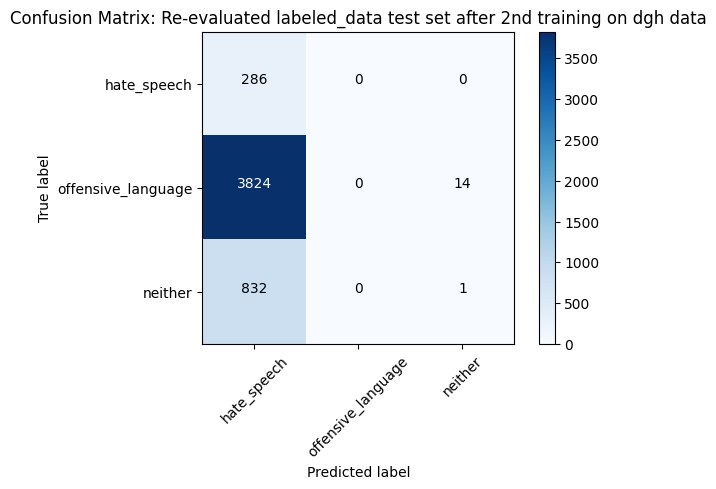

In [64]:
# Predict and calculate confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
# Show confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix: Re-evaluated labeled_data test set after 2nd training on dgh data')
plt.show()

In [65]:
print('F1 = ', f1_score(y_true, y_pred_classes, average='macro'))
print('')
print(classification_report(y_true, y_pred_classes, target_names=['hate_speech','offensive_language','neither']))

F1 =  0.03725645171380039

                    precision    recall  f1-score   support

       hate_speech       0.06      1.00      0.11       286
offensive_language       0.00      0.00      0.00      3838
           neither       0.07      0.00      0.00       833

          accuracy                           0.06      4957
         macro avg       0.04      0.33      0.04      4957
      weighted avg       0.01      0.06      0.01      4957



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Unfinished code below:

In [55]:
# Step 1: Split dgh data into labeled and unlabeled pools
initial_labeled_ratio = 0.1  # Start with 10% labeled data

X_train, X_unlabeled, y_train, y_unlabeled = train_test_split(
    dgh['tweet'], 
    dgh['class'], 
    test_size=1-initial_labeled_ratio, 
    random_state=42, 
    stratify=dgh['class'])

# Step 2: Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_unlabeled_vec = vectorizer.transform(X_unlabeled)

# Step 3: Train the initial model
# model = MultinomialNB()
# model.fit(X_train_vec, y_train)

# Step 4: Active learning loop
num_iterations = 10
samples_per_iteration = 100

for i in range(num_iterations):
    # Predict probabilities on the unlabeled data
    probs = model.predict_proba(X_unlabeled_vec)
    uncertainties = np.max(probs, axis=1)

    # Select the most uncertain samples
    uncertain_indices = uncertainties.argsort()[:samples_per_iteration]
    X_new_train = X_unlabeled.iloc[uncertain_indices]
    y_new_train = y_unlabeled.iloc[uncertain_indices]

    # Remove the selected samples from the unlabeled pool using positional indices
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[uncertain_indices])
    y_unlabeled = y_unlabeled.drop(y_unlabeled.index[uncertain_indices])
    X_unlabeled_vec = vectorizer.transform(X_unlabeled)

    # Transform the new samples with the existing vectorizer
    X_new_train_vec = vectorizer.transform(X_new_train)

    # Append new samples to the training set
    X_train_vec = vstack((X_train_vec, X_new_train_vec))
    y_train = pd.concat([y_train, y_new_train])

    # Retrain the model
    model.fit(X_train_vec, y_train)

    # Evaluate the model
    y_pred = model.predict(X_train_vec)
    accuracy = accuracy_score(y_train, y_pred)
    print(f"Iteration {i+1}/{num_iterations}, Accuracy: {accuracy:.4f}")

# Save updated model
model.save('hs_lstm_active.h5')

AttributeError: 'Sequential' object has no attribute 'predict_proba'

#### Implement keras active learning method (https://keras.io/examples/nlp/active_learning_review_classification/)

In [ ]:
dgh_train = dgh[dgh['split']=='train']
dgh_test = dgh[dgh['split']=='test']
dgh_val = dgh[dgh['split']=='val']

# Separating the negative and positive samples for manual stratification
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

# Creating training, validation and testing splits
x_val, y_val = (
    tf.concat((x_positives[:val_split], x_negatives[:val_split]), 0),
    tf.concat((y_positives[:val_split], y_negatives[:val_split]), 0),
)
x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
)
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)

# Remaining pool of samples are stored separately. These are only labeled as and when required
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negatives, y_pool_negatives)
)
pool_positives = tf.data.Dataset.from_tensor_slices(
    (x_pool_positives, y_pool_positives)
)

print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")

In [ ]:
def train_active_learning_models(
    train_dataset,
    pool_negatives,
    pool_positives,
    val_dataset,
    test_dataset,
    num_iterations=3,
    sampling_size=1000):

    # Creating lists for storing metrics
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    model = keras.saving.load_model('hs_lstm.h5',compile=True, safe_mode=True)

    # Defining checkpoints.
    # The checkpoint callback is reused throughout the training since it only saves the best overall model.
    checkpoint = keras.callbacks.ModelCheckpoint(
        "hs_lstm_active.keras", save_best_only=True, verbose=1
    )
    # Here, patience is set to 4. This can be set higher if desired.
    early_stopping = keras.callbacks.EarlyStopping(patience=4, verbose=1)

    print(f"Starting to train with {len(train_dataset)} samples")
    # Initial fit with a small subset of the training set
    history = model.fit(
        train_dataset.cache().shuffle(20000).batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[checkpoint, early_stopping],
    )

    # Appending history
    losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )

    for iteration in range(num_iterations):
        # Getting predictions from previously trained model
        predictions = model.predict(test_dataset)

        # Generating labels from the output probabilities
        rounded = ops.where(ops.greater(predictions, 0.5), 1, 0)

        # Evaluating the number of zeros and ones incorrectly classified
        _, _, false_negatives, false_positives = model.evaluate(test_dataset, verbose=0)

        print("-" * 100)
        print(
            f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
        )

        # This technique of Active Learning demonstrates ratio based sampling where
        # Number of ones/zeros to sample = Number of ones/zeros incorrectly classified / Total incorrectly classified
        if false_negatives != 0 and false_positives != 0:
            total = false_negatives + false_positives
            sample_ratio_ones, sample_ratio_zeros = (
                false_positives / total,
                false_negatives / total,
            )
        # In the case where all samples are correctly predicted, we can sample both classes equally
        else:
            sample_ratio_ones, sample_ratio_zeros = 0.5, 0.5

        print(
            f"Sample ratio for positives: {sample_ratio_ones}, Sample ratio for negatives:{sample_ratio_zeros}"
        )

        # Sample the required number of ones and zeros
        sampled_dataset = pool_negatives.take(
            int(sample_ratio_zeros * sampling_size)
        ).concatenate(pool_positives.take(int(sample_ratio_ones * sampling_size)))

        # Skip the sampled data points to avoid repetition of sample
        pool_negatives = pool_negatives.skip(int(sample_ratio_zeros * sampling_size))
        pool_positives = pool_positives.skip(int(sample_ratio_ones * sampling_size))

        # Concatenating the train_dataset with the sampled_dataset
        train_dataset = train_dataset.concatenate(sampled_dataset).prefetch(
            tf.data.AUTOTUNE
        )

        print(f"Starting training with {len(train_dataset)} samples")
        print("-" * 100)

        # We recompile the model to reset the optimizer states and retrain the model
        model.compile(
            loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.FalseNegatives(),
                keras.metrics.FalsePositives(),
            ],
        )
        history = model.fit(
            train_dataset.cache().shuffle(20000).batch(256),
            validation_data=val_dataset,
            epochs=20,
            callbacks=[
                checkpoint,
                keras.callbacks.EarlyStopping(patience=4, verbose=1),
            ],
        )

        # Appending the history
        losses, val_losses, accuracies, val_accuracies = append_history(
            losses, val_losses, accuracies, val_accuracies, history
        )

        # Loading the best model from this training loop
        model = keras.models.load_model("hs_lstm_active.keras")

    # Plotting the overall history and evaluating the final model
    plot_history(losses, val_losses, accuracies, val_accuracies)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model


active_learning_model = train_active_learning_models(
    train_dataset, pool_negatives, pool_positives, val_dataset, test_dataset
)

In [ ]:
# Step 5: Final evaluation on original test set
# Predict and calculate confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
y_pred_final = model.predict(vectorizer.transform(df['tweet']))
final_accuracy = accuracy_score(df['class'], y_pred_final)
print(f"Final Accuracy: {final_accuracy:.4f}")